In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def lossFunctionConstant(var):
    """Very simple least squares loss function, solution = 3.
    
    Parameters:
    var - Tensorflow variable to optimize
    
    Returns:
    A tensor that contains the loss value.
    """
    return (var - 3)**2

In [3]:
def lossFunctionPlaceholder(var, placeholder):
    """Loss function to calculate the square root of any given number.
    
    Parameters:
    var - Tensorflow variable to optimize
    
    placeholder - 
    A tensorflow "placeholder" that specifies which number to calculate the square root of.
    Needs to be supplied through feed_dict when invoking session.run().
    """
    return (var**2 - placeholder)**2

In [4]:
def complicatedLossFunction(var1, var2, plh1, plh2):
    """Sample loss function with two variables to optimize as well as two placeholders.
    
    Parameters:
    var1, var2 - variables to optimizer
    
    plh1, plh2 - placeholderes
    """
    return ((plh1 * var1 - 2)**2 + 0.1) * ((plh2 * var2 - 3)**2 + 0.1)

## Example 1 - simple optimization##

In [5]:
# Simple test case:
# 1) Create a variable 
# 2) Specify the loss function
# 3) Create an optimizer
# 4) Create a minimizer operation
# 5) Create and initialize a session
# 6) Minimize!

In [6]:
# operations in this cell set up the computational graph for backpropagation. 
# (not necessary to collect them in a single cell - just making a point)

# Creating a variable with an initial value of 0.0
var1 = tf.Variable(0.0)

# Specifying the loss function
lossfn1 = lossFunctionConstant(var1)

# Creating an optimizer with a constant learning rate
# For this loss function, we know that the Lipschitz constant is 2.
# So we can use a vanilla gradient descent method.
# For the single variable quadratic loss function above, a single step of gradient descent should be sufficient.
lips_const1 = 2
learning_rate1 = 1 / lips_const1
optimizer1 = tf.train.GradientDescentOptimizer(learning_rate1)

# Operation that (internally) 
# a) calculates the gradient for the specified loss function wrt the specified variable
# b) applies the gradient with the chosen optimization scheme (vanilla grad descent here)
# Since we only have one variable, we don't need to specify it explicitly.
minimize_op1 = optimizer1.minimize(lossfn1) 

# Create and initialize a session
session1 = tf.Session()
session1.run(tf.global_variables_initializer())

In [7]:
# Run the optimization procedure

# Individual queries for the initial values
lossval_init1 = session1.run(lossfn1)
varval_init1 = session1.run(var1)
print('Initial loss is', lossval_init1, 'and initial variable value is', varval_init1)

# Actual minimization step
# For this loss function, when the lipschitz constant is supplied, only one step of gradient descent is sufficient. 
session1.run(minimize_op1)

# Querying both loss and variable value at once
lossval_final1, varval_final1 = session1.run([lossfn1, var1])
print('Final loss is', lossval_final1, 'and final variable value is', varval_final1)

Initial loss is 9.0 and initial variable value is 0.0
Final loss is 0.0 and final variable value is 3.0


In [8]:
# Remove everything that tensorflow has so far stored in the memory
tf.reset_default_graph()

## Example 2 - placeholder ##

In [9]:
# More complicated loss function to calculate the square root of any supplied number

# Create a placeholder - have to specify what kind of data it will hold.
placeholder2 = tf.placeholder(dtype=tf.float32)

# variable creation is as before 
# I am not using 0 as an initial value because 0 is a local minimum.
var2 = tf.Variable(0.01)

# to create the loss function, we need the placeholder as a paremeter
lossfn2 = lossFunctionPlaceholder(var2, placeholder2)

# It is not obvious what the lipschitz constant is for this loss function
# we use an adaptive gradient descent optimizer - Adam
# an initial step size of 1e-2 should be a safe value
learning_rate2 = 1e-2
optimizer2 = tf.train.AdamOptimizer(learning_rate2)

# Note that the minimize operation only minimizes the variable, NOT the placeholder
minimize_op2 = optimizer2.minimize(lossfn2)

# if we want to track the gradient value as well
# the var_list argument is not required if we want to calculate the gradients wrt all the variables
grads_and_vars2 = optimizer2.compute_gradients(lossfn2, var_list=[var2])

session2 = tf.Session()
session2.run(tf.global_variables_initializer())

In [12]:
# Trying to calculate the loss without supplying the placeholder doesn't work
try:
    session2.run(lossfn2)
except tf.errors.InvalidArgumentError:
    print('Needs a placeholder')

Needs a placeholder


Initial and final values after 298 steps of iteration
Loss 48.998596 ---> 8.961542e-06
Variable 0.01 ---> 2.6451855


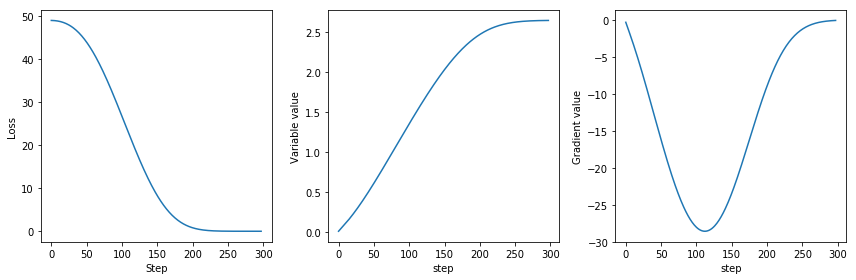

In [13]:
# Run the optimization procedure to calculate the square root of 7
param2 = 7.0
# We are storing the intermediate values for analysis later
lossvals2 = []
varvals2 = []
gradvals2 = []

grads_and_vars_vals_temp, lossval_init2 = session2.run([grads_and_vars2, lossfn2],
                                                       feed_dict={placeholder2: param2})
gradval_init2 = grads_and_vars_vals_temp[0][0]
varval_init2 = grads_and_vars_vals_temp[0][1]
lossvals2.append(lossval_init2)
varvals2.append(varval_init2)
gradvals2.append(gradval_init2)

# 5000 steps of minimization should be sufficient
for i in range(5000):
    # Need to supply the placeholder for the gradient calculation for the minimize op
    session2.run(minimize_op2, feed_dict={placeholder2: param2})
    lossval, grad_var_vals = session2.run([lossfn2, grads_and_vars2], feed_dict={placeholder2:param2})
    lossvals2.append(lossval)
    varvals2.append(grad_var_vals[0][1])
    gradvals2.append(grad_var_vals[0][0])
    
    
    # Stop the optimization if loss is less than 1e-5
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals2))
print('Loss', lossvals2[0], '--->', lossvals2[-1])
print('Variable', varvals2[0], '--->', varvals2[-1])

# Plot the results
plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
plt.plot(lossvals2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.subplot(1,3,2)
plt.plot(varvals2)
plt.xlabel('step')
plt.ylabel('Variable value')
plt.subplot(1,3,3)
plt.plot(gradvals2)
plt.xlabel('step')
plt.ylabel('Gradient value')
plt.tight_layout()
plt.show()

Initial and final values after 434 steps of iteration
Loss 900.1796 ---> 9.571099e-06
Variable 2.6451855 ---> 6.082508


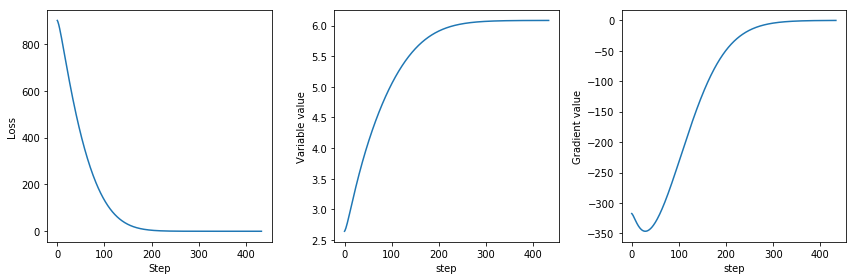

In [14]:
# Using the same computational graph, run the optimization procedure to calculate the square root of 37
param2_new = 37

lossvals_new2 = []
varvals_new2 = []
gradvals_new2 = []

grads_and_vars_vals_temp, lossval_init_new2 = session2.run([grads_and_vars2, lossfn2],
                                                       feed_dict={placeholder2: param2_new})
gradval_init_new2 = grads_and_vars_vals_temp[0][0]
varval_init_new2 = grads_and_vars_vals_temp[0][1]
lossvals_new2.append(lossval_init_new2)
varvals_new2.append(varval_init_new2)
gradvals_new2.append(gradval_init_new2)

# 5000 steps of minimization should be sufficient
for i in range(5000):
    # Need to supply the placeholder for the gradient calculation for the minimize op
    session2.run(minimize_op2, feed_dict={placeholder2: param2_new})
    lossval, grad_var_vals = session2.run([lossfn2, grads_and_vars2], feed_dict={placeholder2:param2_new})
    lossvals_new2.append(lossval)
    varvals_new2.append(grad_var_vals[0][1])
    gradvals_new2.append(grad_var_vals[0][0])
    
    
    # Stop the optimization if loss is less than 1e-5
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals_new2))
print('Loss', lossvals_new2[0], '--->', lossvals_new2[-1])
print('Variable', varvals_new2[0], '--->', varvals_new2[-1])

# Plot the results
plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
plt.plot(lossvals_new2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.subplot(1,3,2)
plt.plot(varvals_new2)
plt.xlabel('step')
plt.ylabel('Variable value')
plt.subplot(1,3,3)
plt.plot(gradvals_new2)
plt.xlabel('step')
plt.ylabel('Gradient value')
plt.tight_layout()
plt.show()

## Example 3 - Changing the variable value manually ##

In [15]:
# What if we want to be able to change the variable value manually?

# Up to minimize op creation is as before
tf.reset_default_graph()

placeholder_loss3 = tf.placeholder(dtype=tf.float32)

var3 = tf.Variable(0.01)

lossfn3 = lossFunctionPlaceholder(var3, placeholder_loss3)

learning_rate3 = 1e-2
optimizer3 = tf.train.AdamOptimizer(learning_rate3)
minimize_op3 = optimizer3.minimize(lossfn3)

In [16]:
# We need to create a placeholder for the manual variable assignment before initializing the session
# Note that the loss function and the optimizer itself don't depend on the variable value.
placeholder_var3 = tf.placeholder(dtype=tf.float32)

# We need to create an operation that handles the assignment
var_assign_op3 = var3.assign(placeholder_var3)

session3 = tf.Session()
session3.run(tf.global_variables_initializer())

In [17]:
# Calculate square root of 987
param3 = 987

# Run 100 steps of optimization
lossvals3 = []
varvals3 = []

varval_init3, lossval_init3 = session3.run([var3, lossfn3], feed_dict={placeholder_loss3: param3})
lossvals3.append(lossval_init3)
varvals3.append(varval_init3)

for i in range(100):
    session3.run(minimize_op3, feed_dict={placeholder_loss3: param3})
    lossval, varval = session3.run([lossfn3, var3], feed_dict={placeholder_loss3:param3})
    lossvals3.append(lossval)
    varvals3.append(varval)
    
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals3))
print('Loss', lossvals3[0], '--->', lossvals3[-1])
print('Variable', varvals3[0], '--->', varvals3[-1])

Initial and final values after 101 steps of iteration
Loss 974168.75 ---> 970403.4
Variable 0.01 ---> 1.3818333


Initial and final values after 467 steps of iteration
Loss 974168.75 ---> 9.313226e-06
Variable 0.01 ---> 31.416508


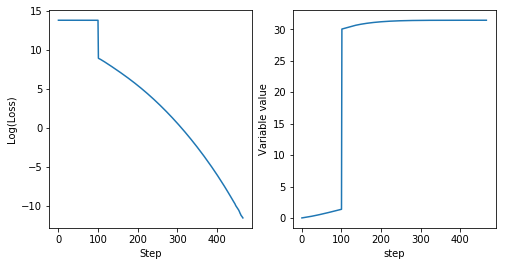

In [18]:
# SUDDENlY, we realize that the square root of 987 is much closer to 30 than to 0.01

# Assign a value to the variable
session3.run(var_assign_op3, feed_dict={placeholder_var3:30})

for i in range(5000):
    session3.run(minimize_op3, feed_dict={placeholder_loss3: param3})
    lossval, varval = session3.run([lossfn3, var3], feed_dict={placeholder_loss3:param3})
    lossvals3.append(lossval)
    varvals3.append(varval)
    
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals3))
print('Loss', lossvals3[0], '--->', lossvals3[-1])
print('Variable', varvals3[0], '--->', varvals3[-1])

# Plot the results
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(np.log(lossvals3))
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
plt.subplot(1,2,2)
plt.plot(varvals3)
plt.xlabel('step')
plt.ylabel('Variable value')
plt.show()

## Example 4 - solving for arrays ##

In [19]:
# What if we want to find the square root of five numbers at once?
tf.reset_default_graph()
params4 = [2, 20, 40, 21, 83]
placeholder_loss4 = tf.placeholder(dtype=tf.float32)

In [20]:
# The variable should now contain 5 different numbers
var4 = tf.Variable([0.01, 0.01, 0.01, 0.01, 0.01])

In [21]:
# For the loss function, we now have to sum the five individual losses
lossfn4 = tf.reduce_sum(lossFunctionPlaceholder(var4, placeholder_loss4))

# This is same as before
learning_rate4 = 1e-2
optimizer4 = tf.train.AdamOptimizer(learning_rate4)
minimize_op4 = optimizer3.minimize(lossfn4)

session4 = tf.Session()
session4.run(tf.global_variables_initializer())

Initial and final values after 1001 steps of iteration
Loss 9333.967 ---> 0.3278637
Variable [0.01 0.01 0.01 0.01 0.01] ---> [1.4142137 4.4721317 6.324522  4.582571  9.078954 ]


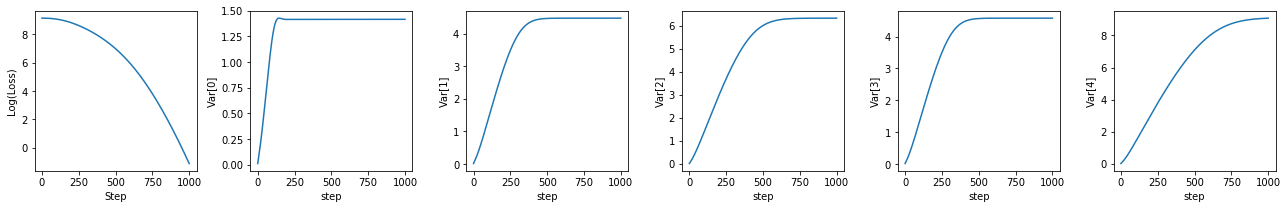

In [22]:
# Run 1000 steps of optimization
lossvals4 = []
varvals4 = [] # This is now a 2d array

varval_init4, lossval_init4 = session4.run([var4, lossfn4], feed_dict={placeholder_loss4: params4})
lossvals4.append(lossval_init4)
varvals4.append(varval_init4)

for i in range(1000):
    session4.run(minimize_op4, feed_dict={placeholder_loss4: params4})
    lossval, varval = session4.run([lossfn4, var4], feed_dict={placeholder_loss4:params4})
    lossvals4.append(lossval)
    varvals4.append(varval)
    
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals4))
print('Loss', lossvals4[0], '--->', lossvals4[-1])
print('Variable', varvals4[0], '--->', varvals4[-1])

        
varvals4 = np.array(varvals4)
        
# Plot the results
plt.figure(figsize=[18,3])
plt.subplot(1,6,1)
plt.plot(np.log(lossvals4))
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
for i in range(2, 7):
    plt.subplot(1,6,i)
    plt.plot(varvals4[:,i-2])
    plt.xlabel('step')
    plt.ylabel('Var[%d]'%(i-2))
plt.tight_layout()
plt.show()

## Example 5 - Alternating minimization for multiple variables ##

For the loss function of the form
$$
f(v_1, v_2) = \left[(\phi_1 v_1 - 2)^2 + 0.1\right]\left[(\phi_2 v_2 - 3)^2 + 0.1\right]
$$
where $v_1, v_2$ are the variables and $\phi_1, \phi_2$ are the placeholders, alternating minimization seems like the best approach

In [23]:
tf.reset_default_graph()

# Using phi1 = 7, phi2 = 32
params5 = [7, 3]
placeholder_loss5 = tf.placeholder(dtype=tf.float32)

In [24]:
# We have to create two separate variables
# I am storing them in a single array just for convenience
vars5 = [tf.Variable(0.1), tf.Variable(0.1)]

lossfn5 = complicatedLossFunction(vars5[0], vars5[1], 
                                  placeholder_loss5[0], placeholder_loss5[1])

# Create two separate optimizers (with separate learning rates)
# And two separate minimization operations
opts5 = [tf.train.AdamOptimizer(1e-2), tf.train.AdamOptimizer(1e-2)]

min_ops5 = [opts5[i].minimize(lossfn5, var_list=vars5[i]) for i in range(2)]

session5 = tf.Session()
session5.run(tf.global_variables_initializer())

Initial and final values after 1001 steps of iteration
Loss 13.2281 ---> 0.01000001
Variable 1 0.1 ---> 0.28571394
Variable 2 0.1 ---> 0.99989784


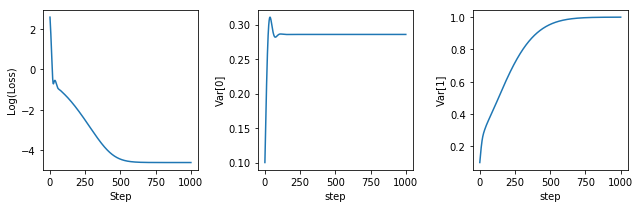

In [25]:
# Run 1000 steps of optimization
lossvals5 = []
varvals5 = []

varvals_init5, lossval_init5 = session5.run([vars5, lossfn5], feed_dict={placeholder_loss5: params5})
lossvals5.append(lossval_init5)
varvals5.append(varvals_init5)

for i in range(1000):
    # Alternating minimization
    # First minimize the variable in vars5[0]
    session5.run(min_ops5[0], feed_dict={placeholder_loss5: params5})
    # Then minimize the variable in vars5[1]
    session5.run(min_ops5[1], feed_dict={placeholder_loss5: params5})
    lossval, varval = session5.run([lossfn5, vars5], feed_dict={placeholder_loss5:params5})
    lossvals5.append(lossval)
    varvals5.append(varval)
    
    if lossval < 1e-5:
        break
print('Initial and final values after %d steps of iteration'%len(lossvals5))
print('Loss', lossvals5[0], '--->', lossvals5[-1])
print('Variable 1', varvals5[0][0], '--->', varvals5[-1][0])
print('Variable 2', varvals5[0][1], '--->', varvals5[-1][1])
varvals5 = np.array(varvals5)
        
# Plot the results
plt.figure(figsize=[9,3])
plt.subplot(1,3,1)
plt.plot(np.log(lossvals5))
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
for i in range(2, 4):
    plt.subplot(1,3,i)
    plt.plot(varvals5[:,i-2])
    plt.xlabel('step')
    plt.ylabel('Var[%d]'%(i-2))
plt.tight_layout()
plt.show()

In [26]:
tf.reset_default_graph()